![](img/330-banner.png)

# Lecture 7: Logistic Regression and Multi-class, Meta-strategies


UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [23]:
import sys
import time

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import sklearn
from IPython.display import HTML
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

## Learning outcomes

From this lecture, students are expected to be able to: 

- Explain the general intuition behind linear models
- Explain the predict paradigm of linear models
- Use `scikit-learn`'s `LogisticRegression` classifier
    - Use `fit`, `predict`, `predict_proba`   
    - Use `coef_` to interpret the model weights 
- Compare logistic regression with naive Bayes    
- Explain the advantages and limitations of linear classifiers 
- Carry out multi-class classification using OVR and OVO strategies. 

## Introduction to linear classifiers 

### Motivating example 

- Consider the problem of predicting sentiment expressed in movie reviews. 
- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *flawless* for 👍 and *boring* for 👎)

<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

### Intuition behind a linear classifier
- Learn coefficients (weights) associated with features
<center>
<img src='./img/words_coeff.png' width="300" height="300" />
</center>    

- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>.
</blockquote>
- Feature vector for $x_i$: [1, 0, 1, 1, 0, 0, 0]
- $score(x_i) = $ coefficient(*boring*) $\times 1$ + coefficient(*excellent*) $\times 1$ + coefficient(*flawless*) $\times 1$ = $-1.40 + 1.93 + 1.43 = 1.96 > 0$, so predict the review as positive 👍. 


### A linear classifier 

A linear classifier is a linear function of $X$ followed by a threshold. 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

Components of a linear classifier:
1. input features ($x_1, \dots, x_d$)
2. coefficients (weights) ($w_1, \dots, w_d$)
3. bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. threshold ($r$)

In our example, we assumed $r=0$ and $b=0$.

<br><br>

## Logistic regression

- A linear model for classification. 
- It learns weights associated with each feature and the bias. 
- The decision boundary is a hyperplane dividing the feature space in half. That's why we call it a linear classifier.
- In this course we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba` 
    - how to use `coef_` to interpret the model

### Logistic regression on the cities data

In [2]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

In [3]:
lr = LogisticRegression()
scores = cross_validate(lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.006854,0.000964,0.852941,0.827068
1,0.005379,0.000817,0.823529,0.827068
2,0.005017,0.000841,0.696970,0.858209
3,0.004982,0.000802,0.787879,0.843284
4,0.005278,0.000806,0.939394,0.805970


### Decision boundary of logistic regression

The decision boundary is a hyperplane dividing the feature space in half.

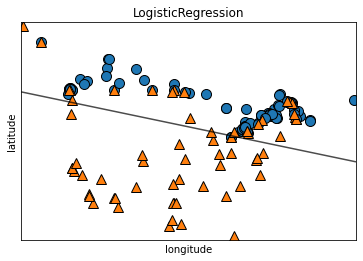

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train)
mglearn.plots.plot_2d_separator(lr, X_train.to_numpy(), fill=False, eps=0.5, alpha=0.7)
plt.title(lr.__class__.__name__)
plt.xlabel("longitude")
plt.ylabel("latitude");

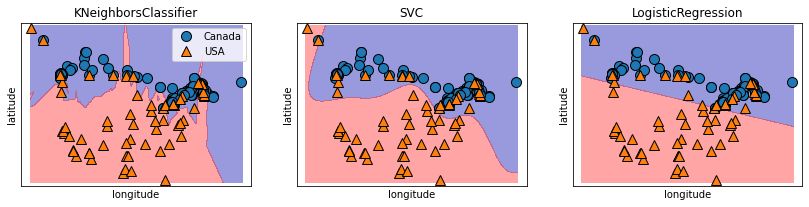

In [14]:
models = {
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(gamma=0.01),
    "logistic Regression": LogisticRegression(),
}

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for model, ax in zip([KNeighborsClassifier(), SVC(gamma=0.01), LogisticRegression()], axes):
    clf = model.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(clf, X_train.to_numpy(), fill=True, eps=0.5,
                                    ax=ax, alpha=.4)
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
axes[0].legend()


- Notice a linear decision boundary (a line in our case). 
- Compare it with  KNN or SVM RBF decision boundaries. 

### Accessing learned weights

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

- How to access these weights? 
    - In `sklearn`, the `coef_` attribute of the `LogisticRegression` object gives the weights of the features.

In [15]:
X_train.columns

Index(['longitude', 'latitude'], dtype='object')

In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))  # these are weights
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term
data = {"features": X_train.columns, "coefficients": lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


,features,coefficients
0,longitude,-0.041081
1,latitude,-0.336831


- Both negative weights 
- The weight of latitude is larger in magnitude. 

### Prediction with learned weights

In [17]:
example = X_test.iloc[0, :]
example.tolist()

[-64.8001, 46.098]

In [18]:
lr.intercept_

array([10.8869838])

Calculate $\hat{y}$ as: ```y_hat = np.dot(w, x) + b```

In [19]:
np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_)

array([-1.97817876])

In [20]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Our threshold here is 0
- The sign is negative and so predict class -1 (Canada in our case). 

In [21]:
lr.predict([example])

array(['Canada'], dtype=object)

### Scores to probabilities 

- The numbers we saw above are "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive, predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".
- You can also have "soft predictions", aka predicted probabilities. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the sigmoid.

#### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$.
$$\frac{1}{1+e^{-x}}$$ 
- Then we can interpret the output as probabilities.
- Recall our hard predictions that check the sign of $w^Tx$, or, in other words, whether or not it is $> 0$.
  - The threshold $w^Tx=0$ corresponds to $p=0.5$. 
  - In other words, if our predicted probability is above $0.5$ then our hard prediction is $+1$.

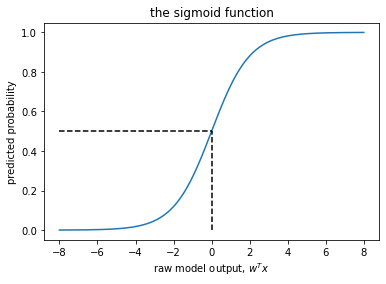

In [22]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

### Predicting probabilities 

- Similar to Naive Bayes, you can get the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method. 

In [ ]:
lr.predict_proba([example])

Let's examine whether we get the same answer if we call sigmoid on $w^Tx + b$

In [ ]:
np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_)

In [ ]:
sigmoid(np.dot(example.tolist(), lr.coef_.flatten()) + (lr.intercept_))

We get the same probability score!!

In [ ]:
# Predicting probabilities
data_dict = {
    "y": y_train[:10],
    "predicted y": lr.predict(X_train[:10]).tolist(),
    "probabilities": lr.predict_proba(X_train[:10]).tolist(),
}
pd.DataFrame(data_dict)

In [ ]:
plot_classifier(X_train[:10], y_train[:10], lr, proba=True, ax=plt.gca())
plt.title("Logistic regression");

### Main hyperparameters

- `C` (More about its interpretation in 573.)
- You will explore this in the lab. 

### Questions

- Can logistic regression work with categorical features? 
- Is scaling important for logistic regression?

<br><br><br><br>

## Model interpretation of linear classifiers

We'll demonstrate this using `LogisticRegression` on Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

In [24]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [25]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


### `fit` and `predict` using `LogisticRegression`

In [26]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression()
)  # pipeline with logistic regression

In [27]:
results = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.068224,0.008855,0.982063,0.995231
1,0.066819,0.008486,0.988789,0.994390
2,0.067360,0.008311,0.968575,0.995233
3,0.065294,0.008150,0.978676,0.994952
4,0.067739,0.009439,0.983165,0.993831


### Finding examples where the model is most confident 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the messages where our classifier is most confident or least confident?

What are the most spam-like text message according to our classifier?

In [28]:
pipe_lr.fit(X_train, y_train)
pipe_lr.classes_

array(['ham', 'spam'], dtype=object)

In [29]:
pipe_lr.predict_proba(X_train)

array([[0.98756516, 0.01243484],
       [0.99821747, 0.00178253],
       [0.99176266, 0.00823734],
       ...,
       [0.98921616, 0.01078384],
       [0.98500909, 0.01499091],
       [0.99247293, 0.00752707]])

In [30]:
spam_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with spam class
spam_probs

array([0.01243484, 0.00178253, 0.00823734, ..., 0.01078384, 0.01499091,
       0.00752707])

Let's get the index of the example where the classifier is most confident (highest `predict_proba` score for spam). 

In [31]:
most_spammy = np.argmax(spam_probs)

- Here is the message where the model is most confident (prediction probability = 1.0) that it's a spam message. 

In [32]:
print("MESSAGE: %s\n" % (X_train.iloc[[most_spammy]]))
print("True target: %s\n" % (y_train.iloc[most_spammy]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_spammy]])[0]))
print("Prediction probability: %0.4f" % (spam_probs[most_spammy]))

MESSAGE: 267    Ur ringtone service has changed! 25 Free credits! Go to club4mobiles.com to choose content now! Stop? txt CLUB STOP to 87070. 150p/wk Club4 PO Box1146 MK45 2WT
Name: sms, dtype: object

True target: spam

Predicted target: spam

Prediction probability: 1.0000


### Exercise for you
- Find the most non-spam like message according to the model. 

### Interpretability of linear classifiers


- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? 
- Suppose you want to examine the words that are indicative of "spam" and "ham" according to the model. 
- The model has learned coefficient for each feature. 
- In linear models, the $j^{th}$  coefficient tells us how feature $j$ affects the prediction. 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 
- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names()` on the `CountVectorizer` object. 

In [33]:
weights = pipe_lr.named_steps["logisticregression"].coef_.flatten()
vocab = pipe_lr.named_steps["countvectorizer"].get_feature_names()
data = {"features": vocab[-500:-490], "coefficient": weights[-500:-490]}
pd.DataFrame(data)

,features,coefficient
0,using,0.064078
1,usmle,-0.000268
2,usps,-0.027594
3,usual,-0.054480
4,usually,-0.039779
5,uterus,-0.010815
6,utter,-0.020199
7,uttered,-0.001877
8,uup,-0.006187
9,uv,-0.015756


- In linear models, the $j^{th}$  coefficient tells us how feature $j$ affects the prediction. 
- So looking at the features which have coefficient with bigger magnitudes might be useful.
- Let's sort the coefficients in descending order

In [34]:
inds = np.argsort(pipe_lr.named_steps["logisticregression"].coef_.flatten())

In [35]:
pipe_lr.classes_

array(['ham', 'spam'], dtype=object)

- Here are 10 words with highest coefficients. 
- Interpretation: if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$

In [36]:
data = {
    "feature": [vocab[index] for index in inds[-10:]],
    "coefficient": [weights[index] for index in inds[-10:]],
}
pd.DataFrame(data)

,feature,coefficient
0,won,1.721252
1,message,1.763130
2,50,1.781997
3,150p,1.787398
4,new,1.848891
5,txt,1.876595
6,claim,1.926252
7,mobile,1.932385
8,service,2.034144
9,uk,2.286523


- Here are 10 words with lowest coefficients. 
- Interpretation: if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$ ("ham" in our case)

In [37]:
data = {
    "feature": [vocab[index] for index in inds[:10]],
    "coefficient": [weights[index] for index in inds[:10]],
}
pd.DataFrame(data)

,feature,coefficient
0,gt,-1.006349
1,lt,-0.996415
2,ll,-0.843388
3,fullonsms,-0.758834
4,think,-0.744617
5,ok,-0.693824
6,happy,-0.690522
7,later,-0.689197
8,way,-0.686187
9,da,-0.684634


Let's look at first 20 words which are associated with "ham" and "spam" messages according to the model. 

In [38]:
ham_words = [vocab[index] for index in inds[:20]]
spam_words = [vocab[index] for index in inds[-20:]]
ham_words_weights = [(weights[index]) for index in inds[:20]]
spam_words_weights = [(weights[index]) for index in inds[-20:]]
pd.DataFrame(
    {
        "ham feats": ham_words,
        "ham weights": ham_words_weights,
        "spam feats": spam_words,
        "spam weights": spam_words_weights,
    }
)

,ham feats,ham weights,spam feats,spam weights
0,gt,-1.006349,18,1.301611
1,lt,-0.996415,88066,1.321332
2,ll,-0.843388,urgent,1.416105
3,fullonsms,-0.758834,ringtone,1.447030
4,think,-0.744617,min,1.456589
5,ok,-0.693824,reply,1.458339
6,happy,-0.690522,chat,1.483470
7,later,-0.689197,text,1.507305
8,way,-0.686187,www,1.546152
9,da,-0.684634,free,1.654350


### Summary: Interpreting learned weights/coefficients 

In linear models: 
- the $j$th coefficient tells us how feature $j$ affects the prediction
- if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$
- if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$
- if $w_j == 0$ then the feature is not used in making a prediction

### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? 
- What about decision trees and naive Bayes?  

## Other linear models

### Linear SVM 

- We have seen non-linear SVM with RBF kernel before. This is the default SVC model in `sklearn` because it tends to work better in many cases. 
- There is also a linear SVM. You can pass `kernel="linear"` to create a linear SVM. 

In [ ]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

In [ ]:
models = {
    "RBF SVM": SVC(gamma=0.01),  # default SVM is RBF SVM
    "Linear SVM": SVC(kernel="linear"),
}

plt.figure(figsize=(10, 5))
i = 0
for name, model in models.items():
    plt.subplot(1, 2, i + 1)
    model.fit(X_train, y_train)
    scores = cross_validate(model, X_train, y_train)
    print("%s mean cv score: %s" % (name, pd.DataFrame(scores).mean()["test_score"]))
    plot_classifier(X_train, y_train, model, ax=plt.gca())
    plt.title(name)
    i += 1

- `predict` method of linear SVM and logistic regression works the same way. 
- We can get `coef_` associated with the features and `intercept_` using a Linear SVM model. 

In [ ]:
linear_svc = SVC(kernel="linear")
linear_svc.fit(X_train, y_train)
print("Model weights: %s" % (linear_svc.coef_))
print("Model intercept: %s" % (linear_svc.intercept_))

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))
print("Model intercept: %s" % (lr.intercept_))

- Note that the coefficients and intercept are slightly different for logistic regression. 
- This is because the `fit` for linear SVM and logistic regression are different. 

### Regression with linear models 

- You'll learn about linear regression in next block. 
- There is `LinearRegression` model in `sklearn`. I recommend using `Ridge` instead; I'll tell you why in the next block. 

In [ ]:
n = 50
X = np.linspace(-1, 1, n) + np.random.randn(n) * 0.01
X = X[:, None]
y = np.random.randn(n, 1) + X * 5
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
grid = np.linspace(min(X_train), max(X_train), 1000)

plt.plot(X_train, y_train, ".", markersize=10)
plt.xlabel("X_train")

plt.ylabel("y_train");

In [ ]:
from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, r.predict(grid))
plt.xlabel("feature")
plt.ylabel("target");

### Summary of linear models 

- The main hyperparameter is the "regularization" hyperparameter controlling the fundamental tradeoff. 
    - Logistic Regression: `C`
    - Linear SVM: `C` 
    - Ridge: `alpha`

### Strengths of linear models 

- Fast to train and predict
- Scale to large datasets and work well with sparse data. 
- Relatively easy to understand and interpret the predictions.
- Perform well when there is a large number of features. 

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.



A few questions you might be thinking about
- How often the real-life data is linearly separable?
- Is the following XOR function linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

- Are linear classifiers very limiting because of this?     

<be><br><br><br>

## Multi-class, meta-strategies

- So far we have been talking about binary classification. 
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision trees for multi-class classification?
- What about logistic regression and SVMs?

Let's create some synthetic data with two features and four classes. 

In [ ]:
from sklearn.datasets import make_blobs

# generate blobs with fixed random generator
X, y = make_blobs(n_samples=500, centers=4, random_state=300)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(*X_train.T, c=y_train, marker=".", cmap="Dark2");

Logistic regression seems to be working without problem on it. 

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
plot_classifier(X_train, y_train, lr);

In [ ]:
lr.classes_

In [ ]:
lr.predict([X_test[0]]), y_test[0]

In [ ]:
lr.predict_proba([X_test[0]])

### Multi-class strategies

- Two common strategies
    - One-vs-rest
    - One-vs-one

By default LogisticRegression uses one-vs-rest strategy to deal with multi-class

### One-vs-rest scheme

- Uses "one-vs-rest" scheme (also known as one-vs-all)
  - turns $k$-class classification into $k$ binary classification problems
  - builds $k$ binary classifiers; for each classifier, the class is fitted against all the other classes
  - each one gives a probability of that class assuming it to be "positive" using the sigmoid function
  - normalize these values across all the classes
  - the class with the maximum value is the prediction 
  - you can do this yourself for any binary classifier using the meta-classifier [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, y_train)
plot_classifier(X_train, y_train, ovr)

In [ ]:
# Here's how one-vs-rest works:
def one_vs_rest_plots(model_class, X, y):
    plt.figure(figsize=(18, 4))
    classes = np.unique(y)
    k = len(classes)
    for i, c in enumerate(classes):
        plt.subplot(1, k, i + 1)

        y_binary = y == c
        model = model_class()
        model.fit(X, y_binary)
        plot_classifier(X, y_binary, model, ax=plt.gca(), proba=True)
        plt.title("Class %d vs rest" % c, fontsize=13)


one_vs_rest_plots(LogisticRegression, X, y)

- You might be wondering about normalization of probabilities here: 
See the following from [`scikit-learn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

> ... calculate the probability of each class assuming it to be positive using the logistic function, and normalize these values across all the classes.

### Multi-class SVMs

- A multi-class linear SVM looks similar, though, by default, it's done with "one-vs-one" instead of one-vs-rest
  - This requires fitting $O(k^2)$ classifiers, where $k$ is number of classes, which is slow.
  - To be precise, it requires fitting $k \times (k − 1)/2$ classifiers; each class gets paired up with all other classes except itself and we divide by 2 because class 1 vs. class 2 classifier is the same as class 2 vs. class 1 classifier.
  - How many models need to be trained for the ImageNet challenge (which has 1000 classes)?
- Note that `SVC` multiclass mode is implemented using one-vs-one scheme whereas `LinearSVC` uses one-vs-rest scheme. 
- That said, we can use the OneVsRestClassifier wrapper to implement one-vs-rest with SVC.
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 
  

In [ ]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
plot_classifier(X_train, y_train, svm);

In [ ]:
# Here's a multi-class nonlinear SVM:
svm_multi = SVC(kernel="rbf", gamma=2, C=100)
svm_multi.fit(X_train, y_train)
plot_classifier(X_train, y_train, svm_multi);

#### When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``

- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

In [ ]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=25, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

plt.scatter(*X_multi.T, c=y_multi, marker=".", cmap="Dark2");

#### Let's examine the time and accuracy of two methods

In [ ]:
model = OneVsOneClassifier(SVC())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

In [ ]:
model = OneVsRestClassifier(SVC())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

Note that there is also a multinomial logistic regression also called **softmax regression** or **the maxent classifier**. This is different than the above multi-class meta strategies. 

## Summary

- Logistic regression is a linear classifier; it has one coefficient per feature, plus an intercept. 
- We combine our features and coefficients: $w_0 + w_1x_1 + w_2x_2 + \ldots + w_dx_d$.
- The decision boundary is a hyperplane dividing the feature space in half.
- You can think of the coefficients as controlling the orientation/tilt of the hyperplane and the bias representing the intercept (offset from the origin). 
- Multi-class classification
    - Two main approaches: OVR, OVO
    - Most of the classifiers you use have native support for multi-class classification (e.g., `LogisticRegression`)
    - But if there is no support, you should use `OneVsOneClassifier` and `OneVsRestClassifier`

### ❓❓ Questions on cross-validation

#### True/False questions on logistic regression

1. The coefficients of a linear classifier have the following interpretation: if coefficient $j$ is large, that means a change in feature $j$ has a large impact on the prediction.
2. For linear classifiers, the decision boundary (the boundary dividing the two classes) is a $d-1$-dimensional hyperplane, where $d$ is the number of features. 
- **Varada's answer**
    - True. For example, in our 2-dimensional cities dataset, the decision boundary is a one-dimensional line.
4. Feature scaling is a good idea for logistic regression.
- **Varada's answer**
True. It's a good idea to carry out feature scaling for logistic regression for feature interpretation. For instance, suppose you have two features $x_1$ which, is either 0 or 1, and $x_2, which is either 0 or 1000$ and if $w_1$ and $w_2$ are equal, the latter is going to have a bigger impact on the prediction because the feature scale is larger. So with different feature scales, it's hard to interpret feature importance simply based on the coefficients. The easiest way to compensate for this is simply to scale features before training.  

### Questions for class discussion

- Can logistic regression work with categorical features?
    - No. We need numerically encoded features for logistic regression.  

### True/False question on multi-class classification

- Suppose you want to train one-vs-rest classifier on a 1000-class problem. Suppose the training time for each binary classifier is $t$. How much time it would take to train the one-vs-rest classifier? 
    1. $1000 \times t$ (correct answer)
    2. $1000^2 \times t$
    3. $((1000)(999)/2) \times t$